In [1]:
# Covers tabular implementations of SERD and IDL and compares their effectivenes

In [2]:
import numpy as np
from envs import MarsExplorerEnv
import matplotlib.pyplot as plt
import time
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
import seaborn as sns
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png
import pickle as pkl
%matplotlib inline

import gym
from gym import spaces
from gym.envs.classic_control import rendering
import tensorflow as tf
from scipy.special import logsumexp
from copy import deepcopy as copy
import random
np.set_printoptions(precision=8, suppress=True,threshold=np.nan)

In [3]:
# %store -r

In [4]:
#%store

In [5]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3
NOOP = 4

cdict = {'red':   ((0.0,  0.173, 0.173),
                   (1.0,  0.925, 0.925)),

         'green': ((0.0,  0.067, 0.067),
                   (1.0, 0.384, 0.384)),

         'blue':  ((0.0,  0.027, 0.027),
                   (1.0,  0.196, 0.196))}
plt.register_cmap(name='RustPlanet', data=cdict)
REWARD_COLORS = cm.get_cmap('RustPlanet')
AGENT_COLORS = cm.get_cmap('gray')
MAP_COLORS = {b'B':"#3a0e00",
              b'F':"#933111",
              b'S':"#933111",
              b'U':"#d65b33",
              b'1':"#956F52",
              b'2':"#3C2F34",
              b'3':"#644C42"}

ROVER_PNGS = {LEFT:"resources/rover_left.png",
        RIGHT:"resources/rover_right.png",
        DOWN:"resources/rover_down.png",
        UP:"resources/rover_up.png",
        NOOP:"resources/rover_sample.png"}

# tile_map = [
#         "F3FFUFU2U",
#         "FUFUSUFUF",
#         "FFFUSUFFU",
#         "USUUUUUSU",
#         "FFUSSSUFF",
#         "FSFUSUFSF",
#         "UUUUUUUFU",
#         "UFFU1UFUU",
#         "3UUFUFFU1"
#     ]

tile_map = [
        "F22222FF1",
        "U31122FU1",
        "UF1112FU1",
        "UFUU1SFU1",
        "UFFU1FFU3",
        "3222UFS1U",
        "UUU22F1FU",
        "FSSFS12SF",
        "FSFF121FF",
        "S1S2SFFSF",
        "FUUUFFSFU",
        "U3UUUFSFU",
        "FFFUUFUUU"
    ]

# tile_map = [
#         "3FFFFFFF1",
#         "FFFFFFFFF",
#         "FFFFUFFFF",
#         "FSFUUUFSF",
#         "FSUU3UUSF",
#         "FSFUUUFSF",
#         "FFFFUFFFF",
#         "FFFSSSFFF",
#         "1FFFFFFF2"
#     ]

tile_rewards = {'F':0.05,
              '1':0.1,
              '2':0.1,
              '3':0.1,
              'S':0.01,
              'U':0.0}


goal_tile_rewards = {'F':0.0,
              '1':1.0,
              '2':2.0,
              '3':4.0,
              'S':0.0,
              'U':0.0}

tile_reward_modifier = lambda r,x,y,mx,my: r * 0.1 * ((x-(mx/2 + np.random.normal(scale=0.5)))**2 + (y - (mx/2 + np.random.normal(scale=0.5)))**2)

def build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier):
    reward_map = np.zeros((len(tile_map),len(tile_map[0])))
    texture_map = np.zeros((len(tile_map),len(tile_map[0])))
    for y,row in enumerate(tile_map):
        for x,c in enumerate(row):
            reward_map[y,x] = texture_map[y,x] = tile_reward_modifier(tile_rewards[c],x,y,len(tile_map[0]),len(tile_map))
            reward_map[y,x] +=  goal_tile_rewards[c]
    return reward_map, texture_map

reward_map, texture_map = build_reward_map(tile_map, tile_rewards, goal_tile_rewards, tile_reward_modifier)


t0 = (0.8,0.1,0.0,0.0)
t1 = (0.0,0.0,0.0,1.0)  #(0.1,0.15,0.5,0.1)

trans_dict = {b'F':t0,
              b'1':t0,
              b'2':t0,
              b'3':t0,
              b'S':t0,
              b'U':t1}

#TODO implement theta_mat in mars_explorer so do not need to hard code, use np.roll
true_tps = np.array([[[0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 0.],
  [0.0, 1.]],

 [[0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.1, 0.],
  [0.0, 1.]],

 [[0.1, 0.],
  [0.0, 0.],
  [0.1, 0.],
  [0.8, 0.],
  [0.0, 1.]],

 [[0., 0.],
  [0., 0.],
  [0., 0.],
  [0., 0.],
  [1., 1.]]])

gamma = 0.98

alpha = 0.0001

T_theta_shape = (5,5,2)

time_penalty = 0.0


In [6]:
# reward_normalizer = (1-gamma)/(np.max(reward_map))
# reward_map *= reward_normalizer
# time_penalty *= reward_normalizer

In [7]:
# temperature = 1/(reward_normalizer)
# print(temperature)

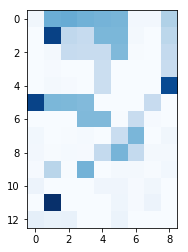

In [8]:
plt.imshow(reward_map, cmap="Blues")

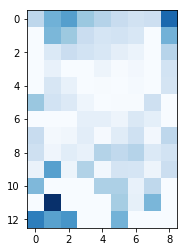

In [9]:
plt.imshow(texture_map, cmap="Blues")

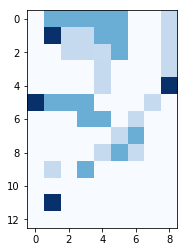

In [10]:
plt.imshow(reward_map - texture_map, cmap="Blues")

In [11]:
mdp = MarsExplorerEnv(tile_map, reward_map, texture_map, trans_dict, time_penalty) 
nA = mdp.num_actions
nS = mdp.num_states

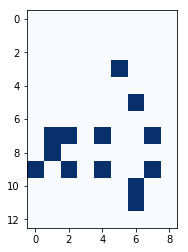

In [12]:
binary_map = np.ones(mdp.tile_map.shape)
binary_map[np.where(mdp.tile_map == b'S')] = 255.0
plt.imshow(binary_map, cmap="Blues")

In [13]:
def plot_mars(mdp, pi, term = 40, title=None, counts = None, Qs = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    s = mdp._reset()
    t, r = 0, 0
    while s is not None and t < term:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        a = pi[s] if type(pi) == np.ndarray else pi(s)
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}      r: {}'.format(t,round(r,4)), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        if Qs is not None:
            print(Qs[s])
            print(a)
            print(softmax(Qs[s]))
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        s, rt, _, d = mdp._step(a)
        print(mdp.s_to_grid(s), mdp.tile_map.flatten()[s])
        t += 1
        r += rt
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_mars_history(mdp, hist, title=None, counts = None):
    background = np.array([colors.to_rgb(MAP_COLORS[l]) for l in mdp.tile_map.flat]).reshape(mdp.nrow, mdp.ncol,3)
    t = 0
    for s,a,sprime in [h[0] for h in hist]:
        fig = plt.figure(figsize=(4,4))
        if title != None:
            plt.title(title)
        plt.imshow(background)
        plt.axes().get_xaxis().set_visible(False)
        plt.axes().get_yaxis().set_visible(False)
        ax = plt.gca()
        img_path = ROVER_PNGS[a]
        arr_hand = read_png(img_path)
        imagebox = OffsetImage(arr_hand, zoom=.5)
        xy = [s%background.shape[1], s//background.shape[1]]  # coordinates to position this image

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(0, 0),
                            xycoords='data',
                            boxcoords="offset points",
                            frameon=False)
        ax.add_artist(ab)
        fig.text(0.13, 0.05, 't: {}'.format(t), ha='left', fontsize=10)
        sns.despine(bottom=True,left=True,right=True,top=True)
        plt.show()
        t += 1
    if counts:
        fig.text(0.87, 0.05, 'F: {}  L/R: {}  B: {}  S: {}'.format(counts['F'], counts['LR'], counts['B'], counts['S']), ha='right', fontsize=10)
    #     plt.savefig(folder+"/"+str(t)+".png", format='png')
    return

def plot_values(mdp, Qs, s=None, title=None):
    V = np.max(Qs, axis=1).reshape((mdp.nrow,mdp.ncol))
    pi = np.argmax(Qs, axis=1)
    plt.figure(figsize=(8,8))
    if title != None:
        plt.title(title)
    plt.imshow(V, cmap='gray')#, clim=(0,1)) 'gist_ncar'
    ax = plt.gca()
    ax.set_xticks(np.arange(V.shape[1])-.5)
    ax.set_yticks(np.arange(V.shape[0])-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:V.shape[0], 0:V.shape[1]]
    a2uv = {0: (-1, 0), 1:(0, -1), 2:(1,0), 3:(0, 1), 4:(-1,-1)}
    Pi = pi.reshape(V.shape)
    for y in range(V.shape[0]):
        for x in range(V.shape[1]):
            a = Pi[y, x]
            u, v = a2uv[a]
            plt.arrow(x, y,u*.3, -v*.3, color='m', head_width=0.2, head_length=0.1) 
            plt.text(x, y, str(mdp.tile_map[y,x].item().decode()),
                     color='c', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
    if s != None:
        plt.plot(s%V.shape[0], s//V.shape[0], 'ro')
#     plt.grid(color='b', lw=2, ls='-')
    return

# Soft-Q Learning

In [14]:
def softmax(x, axis=1):
    """Compute softmax values for each sets of scores in x."""
    axis = 0 if len(x.shape) == 1 else axis
    e_x = np.exp(x - np.max(x, axis=axis,keepdims=True))
    return (e_x / e_x.sum(axis=axis, keepdims = True))

In [15]:
def tabsoftq_iter(R, T, maxiter=10000, verbose=False, Q_init=None, learning_rate=0.5, ftol=1e-32):
    Q = np.zeros((nS, nA)) if Q_init is None else copy(Q_init)
    prevQ = copy(Q)
    if verbose:
        diffs = []
        meanVs = []
    for iter_idx in range(maxiter):
        V = alpha * logsumexp(prevQ / alpha, axis=1)
        V_broad = V.reshape((1, 1, nS))
        Q = np.sum(T * (R + gamma * V_broad), axis=2)
        Q = (1 - learning_rate) * prevQ + learning_rate * Q
        diff = np.mean((Q - prevQ)**2)/(np.std(Q)**2)
        if verbose:
            diffs.append(diff)
            meanVs.append(np.mean(V)) 
        if diff < ftol:
            break
        prevQ = copy(Q)
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Value of All Tiles')
        plt.title('Soft Q Iteration')
        plt.plot(meanVs)
        plt.show()
    return Q

In [16]:
def tabsoftq_learn_Qs(mdp):
    R = mdp.rewards
    T = mdp.get_transition_matrix()
    Qs = tabsoftq_iter(R, T)
    return Qs

def tabsoftq_gen_pol(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return lambda s: np.random.choice(np.asarray(range(len(Qs[s]))),p=softQs[s])

def tabsoftq_gen_pol_probs(Qs, beta=1):
    softQs = softmax(Qs * beta)
    return softQs


In [17]:
def generate_demonstrations(mdp, pol, n, term):
    hists = []
    for i in range(n):
        s, d, t = mdp._reset(), False, 0
        hist = []
        while not d and t < term:
            a = pol[s] if type(pol) == np.ndarray else pol(s)
            sprime, rt, _, ob_dict = mdp._step(a)
            hist += [((s,a,sprime),ob_dict['adt'])]
            t += 1
            s = sprime
        hists += [hist]
    return hists

In [22]:
def tabsoftq_T_grad_iter(T_thetas, Q, R, T=None, maxiter=1000, verbose=True,
                       learning_rate=1, G_init=None, ftol=0):
    
    T_theta_dim = T_thetas.shape[0] * T_thetas.shape[1] * T_thetas.shape[2]
    D = T_thetas.shape[1]
    
    P_broad = tabsoftq_gen_pol_probs(Q).reshape((nS, nA, 1))
    Tps = softmax(T_thetas,axis=1)
    
    if T is None:
        T = mdp.adt_trans_to_sas_trans(Tps)
        
    V = (alpha) * logsumexp(Q * (1 / alpha), axis=1)
    T_grad = np.zeros((nS,nA,T_theta_dim))
    for s in range(nS):
        t = mdp.get_tile_type(s)
        for a in range(nA):
            P_at = Tps[a,:,t]
            V_theta = np.array([V[mdp.sd_to_sprime(s,d)] for d in range(D)])
            R_theta = np.array([R[mdp.sd_to_sprime(s,d)] for d in range(D)])
            VR_theta = R_theta + gamma * V_theta 
            D_probs = np.stack([P_at for _ in range(D)])
            grad_at = np.dot((np.eye(D) - D_probs), VR_theta)
            grad_at = np.dot(np.diag(P_at),grad_at)
            filler = np.zeros(T_thetas.shape)
            filler[a,:,t] = grad_at
            filler = filler.flatten()
            T_grad[s,a] = filler
    G = T_grad if G_init is None else G_init
    T_broad = T.reshape((nS, nA, nS, 1))
    prevG = copy(G)
    if verbose:
        diffs = []
    for iter_idx in range(maxiter):
        expG = np.sum(P_broad * G, axis=1)
        expG_broad = expG.reshape((1, 1, nS, T_theta_dim))
        G = gamma * T_grad
        t_expG = np.sum(T_broad * expG_broad, axis=2)
        G += gamma * t_expG
        G = (1 - learning_rate) * prevG + learning_rate * G
    
        diff = np.mean((G - prevG)**2)/(np.std(G)**2)
        if verbose:
            diffs.append(diff)
        if diff < ftol:
            break
        prevG = copy(G)
  
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Gradient Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
    expG = np.sum(P_broad * G, axis=1)
    expG_broad = expG.reshape((nS, 1, T_theta_dim))
    return (G - expG_broad)

In [18]:
def vectorize_rollouts(rollouts):
    sas_obs = []
    adt_obs = []
    task_idxes = []
    for rollout in rollouts:
        more_sas, more_adt = list(zip(*rollout))
        sas_obs.extend(more_sas)
        adt_obs.extend(more_adt)
    return np.array(sas_obs), np.array(adt_obs)

Sanity check (env and softq)

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


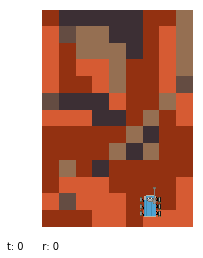

[130.31584585  27.33892058 118.62443437 148.44385267 145.52380679]
3
[0.00000001 0.         0.         0.94882851 0.05117147]
(6, 11) b'S'
(6, 10) b'S'


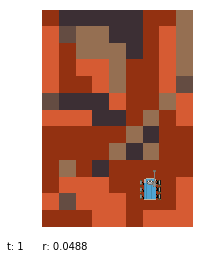

[150.09576005 146.05828761 147.32220218 154.43629587 151.38905135]
3
[0.01227393 0.00021654 0.00076638 0.94200759 0.04473556]
(6, 10) b'S'
(6, 9) b'F'


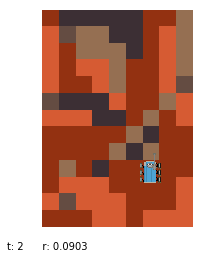

[155.38141065 151.88085901 153.13086346 159.07969971 155.99631711]
3
[0.02306105 0.000696   0.00242929 0.93116264 0.04265103]
(6, 9) b'F'
(6, 8) b'1'


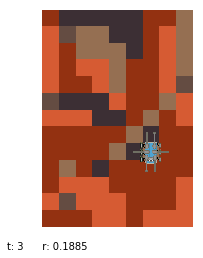

[159.41988276 156.3672531  157.06382828 162.46160854 160.38760223]
4
[0.04046074 0.00191114 0.00383542 0.84730264 0.10649006]
(6, 8) b'1'
(6, 8) b'1'


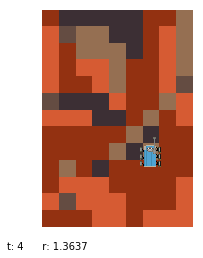

[159.41988276 156.3672531  157.06382828 162.46160854 160.38760223]
3
[0.04046074 0.00191114 0.00383542 0.84730264 0.10649006]
(6, 8) b'1'
(6, 7) b'2'


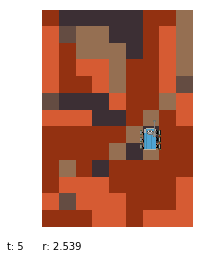

[161.33445666 160.33166799 160.10873935 164.79352988 163.61426141]
3
[0.023136   0.00848756 0.00679151 0.73543578 0.22614915]
(6, 7) b'2'
(6, 6) b'1'


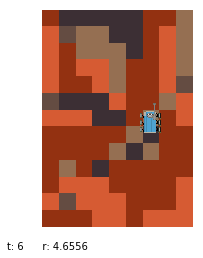

[163.32473516 163.18686284 161.7494042  168.2460833  165.96492959]
3
[0.00652394 0.00568372 0.00135006 0.89500314 0.09143913]
(6, 6) b'1'
(6, 5) b'S'


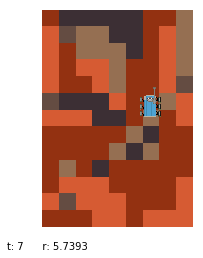

[167.87471207 164.47584728 154.37447216 173.4037815  169.93828699]
3
[0.00383411 0.0001281  0.00000001 0.96584776 0.03019003]
(6, 5) b'S'
(6, 4) b'F'


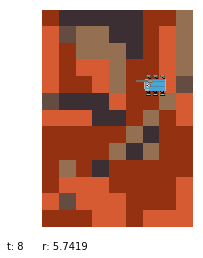

[180.73199532 154.11582822  35.42302422 165.54829087 177.12484737]
0
[0.9735872  0.         0.         0.00000025 0.02641255]
(6, 4) b'F'
(5, 4) b'F'


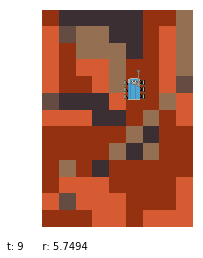

[166.46306557 167.63539999 177.30549644 185.34887963 181.64410011]
3
[0.00000001 0.00000002 0.00031341 0.97567935 0.02400722]
(5, 4) b'F'
(4, 4) b'1'


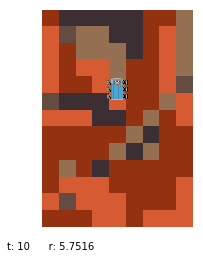

[ 18.47225369  18.17150763 163.78122478 165.88644716 163.57180878]
3
[0.         0.         0.09980054 0.81925546 0.080944  ]
(4, 4) b'1'
(4, 3) b'1'


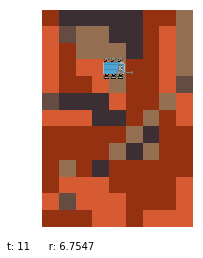

[ 36.09873827 149.7681374  187.3716433  176.79267756 184.65156066]
2
[0.         0.         0.93817893 0.00002387 0.0617972 ]
(4, 3) b'1'
(5, 3) b'S'


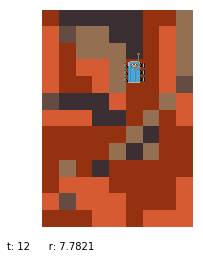

[185.39396438 182.20332268 185.05580809 192.95448932 189.09901752]
3
[0.00050936 0.00002096 0.00036321 0.97839999 0.02070648]
(5, 3) b'S'
(4, 3) b'1'


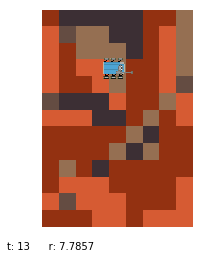

[ 36.09873827 149.7681374  187.3716433  176.79267756 184.65156066]
2
[0.         0.         0.93817893 0.00002387 0.0617972 ]
(4, 3) b'1'
(5, 3) b'S'


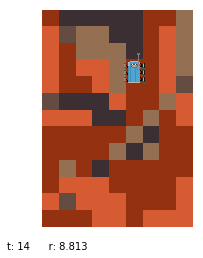

[185.39396438 182.20332268 185.05580809 192.95448932 189.09901752]
3
[0.00050936 0.00002096 0.00036321 0.97839999 0.02070648]
(5, 3) b'S'
(5, 2) b'2'


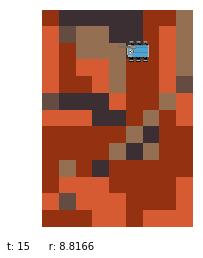

[196.57304067 189.99727875 190.55358414 196.96727862 195.0830584 ]
0
[0.36866973 0.00051383 0.00089623 0.54683065 0.08308955]
(5, 2) b'2'
(5, 3) b'S'


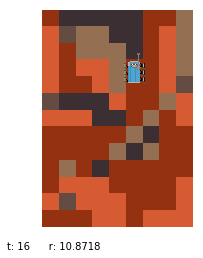

[185.39396438 182.20332268 185.05580809 192.95448932 189.09901752]
3
[0.00050936 0.00002096 0.00036321 0.97839999 0.02070648]
(5, 3) b'S'
(5, 2) b'2'


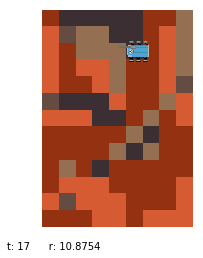

[196.57304067 189.99727875 190.55358414 196.96727862 195.0830584 ]
0
[0.36866973 0.00051383 0.00089623 0.54683065 0.08308955]
(5, 2) b'2'
(5, 3) b'S'


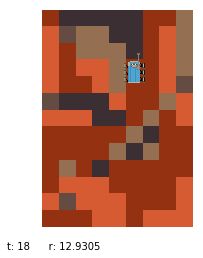

[185.39396438 182.20332268 185.05580809 192.95448932 189.09901752]
3
[0.00050936 0.00002096 0.00036321 0.97839999 0.02070648]
(5, 3) b'S'
(5, 2) b'2'


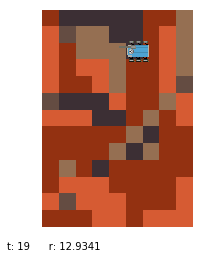

[196.57304067 189.99727875 190.55358414 196.96727862 195.0830584 ]
0
[0.36866973 0.00051383 0.00089623 0.54683065 0.08308955]
(5, 2) b'2'
(4, 2) b'1'


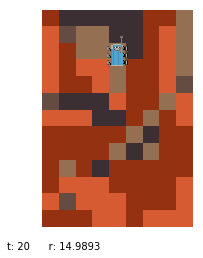

[198.86945413 187.26881768 194.62179439 200.26910201 197.35248398]
3
[0.18912692 0.00000173 0.00270407 0.76667746 0.04148982]
(4, 2) b'1'
(4, 1) b'2'


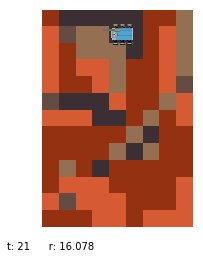

[202.86128258 198.0720325  197.8393478  199.0291294  200.90191608]
0
[0.84924171 0.00706458 0.005598   0.01839706 0.11969865]
(4, 1) b'2'
(3, 1) b'1'


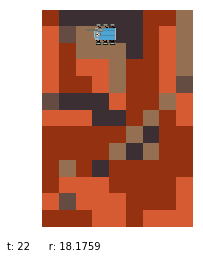

[207.09931074 201.26271553 200.95350389 202.4902708  204.08893584]
0
[0.93958842 0.00274244 0.00201302 0.00935959 0.04629653]
(3, 1) b'1'
(3, 0) b'2'


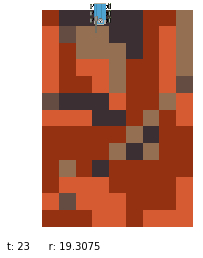

[185.66234637 203.7826172  179.24876629  40.51777753 201.92707715]
1
[0.00000001 0.86477625 0.         0.         0.13522374]
(3, 0) b'2'
(3, 1) b'1'


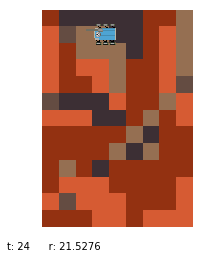

[207.09931074 201.26271553 200.95350389 202.4902708  204.08893584]
0
[0.93958842 0.00274244 0.00201302 0.00935959 0.04629653]
(3, 1) b'1'
(2, 1) b'1'


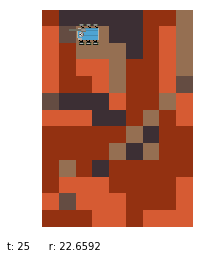

[211.59753087 204.50281206 204.27392851 206.98590162 208.58417464]
0
[0.94290574 0.00078212 0.00062211 0.00936835 0.04632168]
(2, 1) b'1'
(1, 1) b'3'


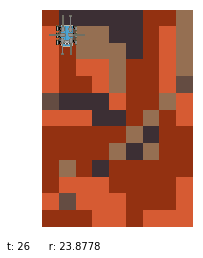

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


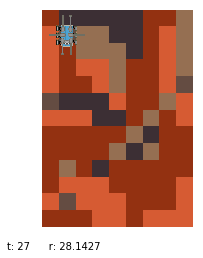

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


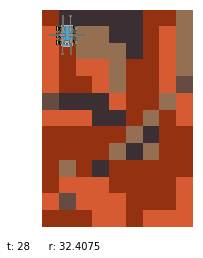

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


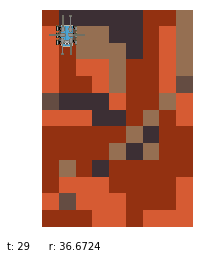

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


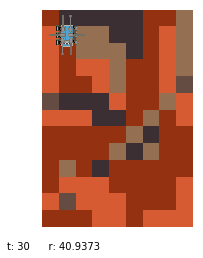

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


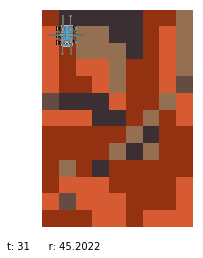

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


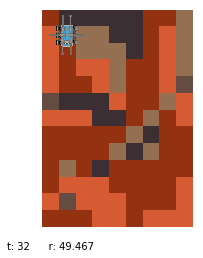

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


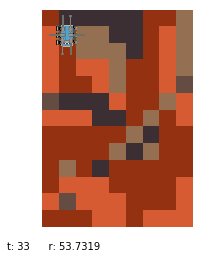

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


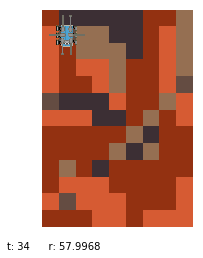

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


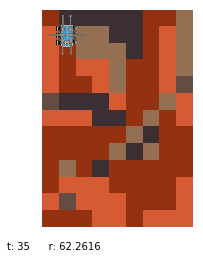

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


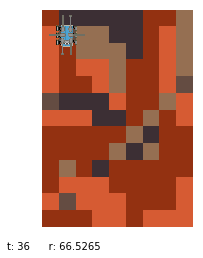

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


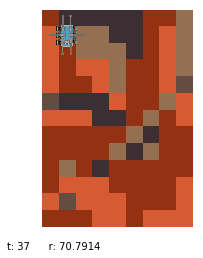

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


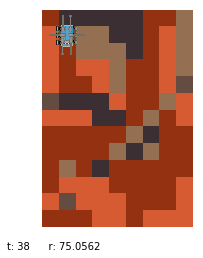

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


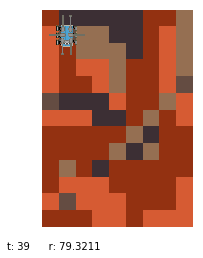

[ 40.61892545 177.27481783 207.47995617 189.34452599 213.24343878]
4
[0.         0.         0.00313033 0.         0.99686967]
(1, 1) b'3'
(1, 1) b'3'


In [19]:
Q = tabsoftq_learn_Qs(mdp)
plot_mars(mdp,tabsoftq_gen_pol(Q),Qs=Q)


In [20]:
print(mdp.feature_map)

AttributeError: 'MarsExplorerEnv' object has no attribute 'feature_map'

# Inverse Dynamics Learning

In [66]:
def transition_grad(adt, tps):
    a,d,t = adt
    grad_theta_t = np.zeros(tps.shape)
    grad_theta_t[a,d,t] += 1
    grad_theta_t[a,:,t] -= tps[a,:,t]
    return grad_theta_t


In [67]:
def eval_pol_likelihood(Q, sas_obs, verbose=False):
    ll = 0.0
    for obs in sas_obs:
        s,a,sprime = obs
        l = np.log(softmax(Q[s])[a])
        ll += l
    return ll

def eval_trans_likelihood(Tps, adt_obs, verbose=False):
    ll = 0.0
    for obs in adt_obs:
        a,d,t, = obs
        print(Tps[a,d,t])
        l = np.log(Tps[a,d,t])
        ll += l
    return ll

def eval_trans_likelihood_and_grad(T_thetas, adt_obs):
    Tps = softmax(T_thetas,axis=1)
    dT = sum([transition_grad(adt,Tps) for adt in adt_obs]).reshape(T_thetas.shape) / len(adt_obs)
    ll = eval_trans_likelihood(Tps, adt_obs)
    return ll, dT

def eval_demo_log_likelihood(sas_obs, adt_obs, T_thetas, Q):
    Tps = softmax(T_thetas,axis=1)
    p_ll = eval_pol_likelihood(Q, sas_obs)
    t_ll = eval_trans_likelihood(Tps, adt_obs)
    return p_ll, t_ll
        

In [24]:
def eval_T_pol_likelihood_and_grad(T_thetas, R, sas_obs, Q_inits=None, verbose=False):
    s = [obs[0] for obs in sas_obs]
    a = [obs[1] for obs in sas_obs]
    Tps = softmax(T_thetas,axis=1)
    T = mdp.adt_trans_to_sas_trans(Tps)
    Q = tabsoftq_iter(R, T, Q_init=Q_inits, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose,
                      ftol=tabsoftq_iter_ftol)
    dT = tabsoftq_T_grad_iter(T_thetas, Q, R, T=T, maxiter=tabsoftq_grad_iter_maxiter,
        verbose=tabsoftq_grad_iter_verbose, ftol=tabsoftq_grad_iter_ftol)
    # Sum instead of mean because sparse results
    if verbose:
        for obs in sas_obs:
            print(obs)
            print(dT[obs[0],obs[1]].reshape(T_thetas.shape))
    dT = np.sum(dT[s,a], axis=0).reshape(T_thetas.shape) / len(sas_obs)
    ll = eval_pol_likelihood(Q, sas_obs)
    return ll, dT, Q


# Simultaneous Estimation of Rewards and Dynamics

In [25]:
def tabsoftq_TR_grad_iter(T_thetas, feat_map, R,  Q, T=None, maxiter=1000, verbose=True,
                       learning_rate=1, G_init=None, ftol=0):
    
    T_theta_dim = T_thetas.shape[0] * T_thetas.shape[1] * T_thetas.shape[2]
    D = T_thetas.shape[1]
    
    R_theta_dim = feat_map.shape[1]
    
    P_broad = tabsoftq_gen_pol_probs(Q).reshape((nS, nA, 1))
    Tps = softmax(T_thetas,axis=1)
    
    if T is None:
        T = mdp.adt_trans_to_sas_trans(Tps)
        
    V = (alpha) * logsumexp(Q * (1 / alpha), axis=1)
    
    R_grad = T.dot(feat_map)
    
    GR = np.zeros((nS, nA, R_theta_dim)) if G_init is None else G_init[0]
    prevGR = copy(GR)
    
    T_grad = np.zeros((nS,nA,T_theta_dim))
    for s in range(nS):
        t = mdp.get_tile_type(s)
        for a in range(nA):
            P_at = Tps[a,:,t]
            V_t = np.array([V[mdp.sd_to_sprime(s,d)] for d in range(D)])
            R_t = np.array([R[mdp.sd_to_sprime(s,d)] for d in range(D)])
            VR_t = R_t + gamma * V_t 
            D_probs = np.stack([P_at for _ in range(D)])
            grad_at = np.dot((np.eye(D) - D_probs), VR_t)
            grad_at = np.dot(np.diag(P_at),grad_at)
            filler = np.zeros(T_thetas.shape)
            filler[a,:,t] = grad_at
            filler = filler.flatten()
            T_grad[s,a] = filler
              
    GT = T_grad if G_init is None else G_init[1]
    T_broad = T.reshape((nS, nA, nS, 1))
    prevGT = copy(GT)
    
    if verbose:
        diffs = []
        
    for iter_idx in range(maxiter):
        # Reward Param gradient iteration
        expGR = np.sum(P_broad * GR, axis=1)
        expGR_broad = expGR.reshape((1, 1, nS, R_theta_dim))
        GR = R_grad + gamma * np.sum(T_broad * expGR_broad, axis=2)
        GR = (1 - learning_rate) * prevGR + learning_rate * GR
        
        
        # Transition Param grad iter
        expGT = np.sum(P_broad * GT, axis=1)
        expGT_broad = expGT.reshape((1, 1, nS, T_theta_dim))
        GT = gamma * T_grad
        t_expGT = np.sum(T_broad * expGT_broad, axis=2)
        GT += gamma * t_expGT
        GT = (1 - learning_rate) * prevGT + learning_rate * GT
    
        diff = np.mean((GR - prevGR)**2)/(np.std(GR)**2) + np.mean((GT - prevGT)**2)/(np.std(GT)**2)
        if verbose:
            diffs.append(diff)
        if diff < ftol:
            break
        prevGR = copy(GR)
        prevGT = copy(GT)
  
    if verbose:
        plt.xlabel('Number of Iterations')
        plt.ylabel('Avg. Squared Bellman Error')
        plt.title('Soft Q Gradient Iteration')
        plt.plot(diffs)
        plt.yscale('log')
        plt.show()
  
    expGR = np.sum(P_broad * GR, axis=1)
    expGR_broad = expGR.reshape((nS, 1, R_theta_dim))
    expGT = np.sum(P_broad * GT, axis=1)
    expGT_broad = expGT.reshape((nS, 1, T_theta_dim))
    return (GR - expGR_broad), (GT - expGT_broad)

In [26]:
def eval_TR_pol_likelihood_and_grad(T_thetas, R, feat_map, sas_obs, Q_inits=None, verbose=False):
    s = [obs[0] for obs in sas_obs]
    a = [obs[1] for obs in sas_obs]
    Tps = softmax(T_thetas,axis=1)
    T = mdp.adt_trans_to_sas_trans(Tps)
    Q = tabsoftq_iter(R, T, Q_init=Q_inits if Q_inits is not None else None, 
        maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    dR, dT = tabsoftq_TR_grad_iter(T_thetas, feat_map, R, Q, T=T,
        maxiter=tabsoftq_grad_iter_maxiter, verbose=tabsoftq_grad_iter_verbose, ftol=tabsoftq_grad_iter_ftol)
    if verbose:
        for obs in sas_obs:
            print(obs)
            print(dT[obs[0],obs[1]].reshape(T_thetas.shape))
    dR = np.sum(dR[s,a], axis=0).reshape(feat_map.shape[1]) / len(sas_obs)
    dT = np.sum(dT[s,a], axis=0).reshape(T_thetas.shape) / len(sas_obs)
    ll = eval_pol_likelihood(Q, sas_obs)
    return ll, dT, dR, Q

# IDL & SERD Experiments

In [27]:
tabsoftq_iter_ftol = 1e-32
tabsoftq_iter_maxiter = 5000
tabsoftq_iter_verbose = False
tabsoftq_grad_iter_ftol = 1e-10
tabsoftq_grad_iter_maxiter = 5000
tabsoftq_grad_iter_verbose = False
batch_size = 200
n_demos = 80
demo_time_steps = 40

In [28]:
def clean_demos(sas_obs):
    demo_example_idxes = list(range(len(sas_obs)))
    unique_stays = set([])
    for i,sas in enumerate(sas_obs):
        sas = tuple(sas)
        if sas[1] == 4:
            if sas in unique_stays:
                demo_example_idxes.remove(i)
            else:
                unique_stays.add(sas)
    return demo_example_idxes

def sample_batch(size, ids, sas_obs, adt_obs):
    idxes = random.sample(ids, size)
    return sas_obs[idxes], adt_obs[idxes]

In [29]:
def T_estimate(adt_obs):
    stability = 1e-5
    T_thetas = np.zeros(T_theta_shape)
    T_counts = np.zeros(T_theta_shape) + stability
    for a,d,t in adt_obs:
        T_counts[a,d,t] += 1
    for a in range(T_theta_shape[0]):
        for t in range(T_theta_shape[2]):
            z = np.sum(T_counts[a,:,t])
            for d in range(T_theta_shape[1]):
                if z == T_counts.shape[1] * stability:
                    T_thetas[a,d,t] = 0
                else:
                    T_thetas[a,d,t] = np.log(T_counts[a,d,t]) - np.log(z)
    return T_thetas

def test_T_likelihood(Tps, sas_obs, adt_obs):
    T = mdp.adt_trans_to_sas_trans(Tps)
    R = mdp.rewards
    Q = tabsoftq_iter(R, T, Q_init=None, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)
    pl = eval_pol_likelihood(Q, sas_obs, verbose=True)
    tl = eval_trans_likelihood(Tps, adt_obs, verbose=True)
    print([s for s in range(nS) if mdp.get_tile_type(s)==1])
    print(Q[[s for s in range(nS) if mdp.get_tile_type(s)==1]])
    print(pl, tl)
    return pl + tl

def true_trans_loss(tps):
    tps = mdp.adt_trans_to_sas_trans(tps)
    true_tps = mdp.get_transition_matrix()
    return np.linalg.norm(true_tps-tps)/nA

In [30]:
exQs = tabsoftq_learn_Qs(mdp)
demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs), n_demos, demo_time_steps)
sas_obs, adt_obs = vectorize_rollouts(demos)

In [31]:
# Ensure bad areas have not been visited in exes
while len(set([adt[2] for adt in adt_obs])) > 1:
    demos = generate_demonstrations(mdp, tabsoftq_gen_pol(exQs), n_demos, demo_time_steps)
    sas_obs, adt_obs = vectorize_rollouts(demos)

In [69]:
# Clean training set to have greater density of interesting transitions
# print(len(sas_obs))
# demo_example_idxes = clean_demos(sas_obs)
# print(len(demo_example_idxes))
demo_example_idxes = list(range(len(sas_obs)))


In [70]:
random.shuffle(demo_example_idxes)
n_train_demo_examples = int(0.9 * len(demo_example_idxes))
train_demo_example_idxes = demo_example_idxes[:n_train_demo_examples]
val_demo_example_idxes = demo_example_idxes[n_train_demo_examples:]
val_sas_obs = sas_obs[val_demo_example_idxes]
val_adt_obs = adt_obs[val_demo_example_idxes]

## IDL Only

In [71]:
idl_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [72]:
maxiter = 500
learning_rate = 0.25

In [73]:
Ti_thetas = T_estimate(adt_obs[train_demo_example_idxes])
Qi, Ri = None, mdp.rewards

In [74]:
while len(idl_train_logs['tt_lls']) < maxiter:
    batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
    #Should we initialize Qs or nah?
    tp_ll, dT_pol, Qi = eval_T_pol_likelihood_and_grad(Ti_thetas, Ri, batch_demo_sas, Q_inits=Qi)
    tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ti_thetas, batch_demo_adt)
    train_likelihood = tp_ll + tt_ll
    vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ti_thetas, Qi)
    val_likelihood = vp_ll + vt_ll
    ttd = true_trans_loss(softmax(Ti_thetas))
    Ti_thetas += learning_rate * (dT_trans + dT_pol)
    
    print('%d %f %f %f %f' % (len(idl_train_logs['tt_lls']), vp_ll, vt_ll, vp_ll + vt_ll, ttd))
    idl_train_logs['train_likelihoods'].append(train_likelihood)
    idl_train_logs['val_likelihoods'].append(val_likelihood)
    idl_train_logs['tp_lls'].append(tp_ll)
    idl_train_logs['tt_lls'].append(tt_ll)
    idl_train_logs['vp_lls'].append(vp_ll)
    idl_train_logs['vt_lls'].append(vt_ll)
    idl_train_logs['true_trans_loss'].append(ttd)

0.8155892950960747
0.9999999714285724
0.9999999714285724
0.8102940727724945
0.8047617607710092
0.08365020117393523
0.8102940727724945
0.9999999714285724
0.9999999714285724
0.9999999714285724
0.8102940727724945
0.9999999714285724
0.9999999714285724
0.8155892950960747
0.9999999714285724
0.9999999714285724
0.8102940727724945
0.9999999714285724
0.9999999714285724
0.9999999714285724
0.8155892950960747
0.8102940727724945
0.9999999714285724
0.9999999714285724
0.9999999714285724
0.8102940727724945
0.9999999714285724
0.9999999714285724
0.8102940727724945
0.9999999714285724
0.07500000919117582
0.9999999714285724
0.8047617607710092
0.8102940727724945
0.10937507080072592
0.9999999714285724
0.9999999714285724
0.9999999714285724
0.8047617607710092
0.9999999714285724
0.8102940727724945
0.10076046570718006
0.8155892950960747
0.9999999714285724
0.8155892950960747
0.9999999714285724
0.9999999714285724
0.9999999714285724
0.8155892950960747
0.8102940727724945
0.9999999714285724
0.8102940727724945
0.999999

0.99999997142857
0.99999997142857
0.99999997142857
0.10603958595122986
0.8176190962336298
0.99999997142857
0.7621199822606981
0.99999997142857
0.99999997142857
0.8105189533845016
0.8176190962336298
0.99999997142857
0.8105189533845016
0.99999997142857
0.8105189533845016
0.99999997142857
0.99999997142857
0.99999997142857
0.99999997142857
0.8105189533845016
0.99999997142857
0.11494474650465425
0.8176190962336298
0.11494474650465425
0.99999997142857
0.99999997142857
0.8105189533845016
0.99999997142857
0.8021700483695251
0.99999997142857
0.99999997142857
0.07453627073675059
0.8105189533845016
0.8105189533845016
0.8176190962336298
0.8021700483695251
0.99999997142857
0.8176190962336298
0.99999997142857
0.8176190962336298
0.8021700483695251
0.99999997142857
0.8021700483695251
0.99999997142857
0.8105189533845016
0.8176190962336298
0.99999997142857
0.8105189533845016
0.99999997142857
0.10603958595122986
0.99999997142857
0.99999997142857
0.99999997142857
0.8021700483695251
0.99999997142857
0.0917

0.9999999714285673
0.7514835738867125
0.8165977564287611
0.8165977564287611
0.8165977564287611
0.0829398804771872
0.8158349877496786
0.9999999714285673
0.8165977564287611
0.8165977564287611
0.9999999714285673
0.9999999714285673
0.7990739071954913
0.8158349877496786
0.9999999714285673
0.9999999714285673
0.9999999714285673
0.8165977564287611
0.8158349877496786
0.11249786621516403
0.8158349877496786
0.9999999714285673
0.7990739071954913
0.8165977564287611
0.7990739071954913
0.9999999714285673
0.8165977564287611
0.9999999714285673
0.8158349877496786
0.8158349877496786
0.9999999714285673
0.8158349877496786
0.11249786621516403
0.8158349877496786
0.9999999714285673
0.9999999714285673
0.8158349877496786
0.8165977564287611
0.9999999714285673
0.8158349877496786
0.9999999714285673
0.8165977564287611
0.11249786621516403
0.9999999714285673
0.9999999714285673
0.8158349877496786
0.9999999714285673
0.9999999714285673
0.9999999714285673
0.9999999714285673
0.9999999714285673
0.9999999714285673
0.8165977

0.9999999714285651
0.9999999714285651
0.0947282710387323
0.9999999714285651
0.9999999714285651
0.818081287642599
0.7968398633815835
0.11165434102055054
0.07026434272406308
0.9999999714285651
0.9999999714285651
0.8133140884645763
0.11165434102055054
0.9999999714285651
0.8133140884645763
0.07026434272406308
0.818081287642599
0.7968398633815835
0.9999999714285651
0.818081287642599
0.10321784599406444
0.9999999714285651
0.818081287642599
0.9999999714285651
0.9999999714285651
0.9999999714285651
0.818081287642599
0.7968398633815835
0.818081287642599
0.9999999714285651
0.9999999714285651
0.8133140884645763
0.9999999714285651
0.818081287642599
0.818081287642599
0.8133140884645763
0.8133140884645763
0.818081287642599
0.9999999714285651
0.9999999714285651
0.9999999714285651
0.9999999714285651
0.7968398633815835
0.8133140884645763
0.9999999714285651
0.9999999714285651
0.9999999714285651
0.9999999714285651
0.818081287642599
0.7968398633815835
0.8133140884645763
0.9999999714285651
0.999999971428565

KeyboardInterrupt: 

In [ ]:
plt.plot(idl_train_logs['vp_lls'])

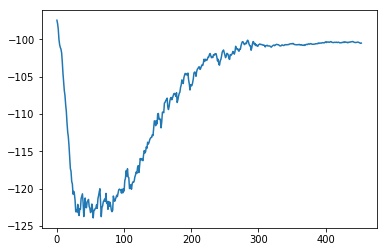

In [53]:
plt.plot(idl_train_logs['vt_lls'])

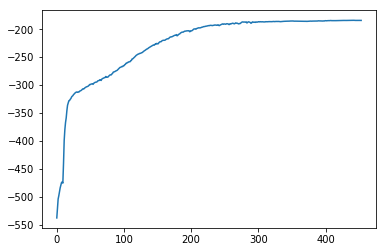

In [54]:
plt.plot(idl_train_logs['val_likelihoods'])

In [55]:
print(Qi[[s for s in range(nS) if mdp.get_tile_type(s)==1]])

[[112.55994512 112.55994512 112.55994512 112.55994512 112.55994512]
 [108.61902234 108.61902234 108.61902234 108.61902234 108.61902234]
 [100.85360138 100.85360138 100.85360138 100.85360138 100.85360138]
 [102.70411834 102.70411834 102.70411834 102.70411834 102.70411834]
 [105.05166138 105.05166138 105.05166138 105.05166138 105.05166138]
 [108.37032213 108.37032213 108.37032213 108.37032213 108.37032213]
 [ 97.41982891  97.41982891  97.41982891  97.41982891  97.41982891]
 [106.49110794 106.49110794 106.49110794 106.49110794 106.49110794]
 [127.7354447  127.7354447  127.7354447  127.7354447  127.7354447 ]
 [106.69441834 106.69441834 106.69441834 106.69441834 106.69441834]
 [117.88311002 117.88311002 117.88311002 117.88311002 117.88311002]
 [113.13706867 113.13706867 113.13706867 113.13706867 113.13706867]
 [114.07227754 114.07227754 114.07227754 114.07227754 114.07227754]
 [ 81.83961409  81.83961409  81.83961409  81.83961409  81.83961409]
 [ 77.92880604  77.92880604  77.92880604  77.928

/Users/mckaneandrus/anaconda2/envs/irld/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


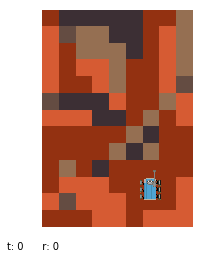

(6, 10) b'S'
(6, 9) b'F'


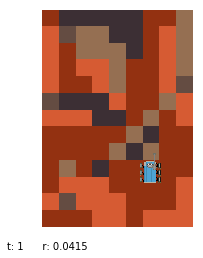

(6, 9) b'F'
(5, 9) b'F'


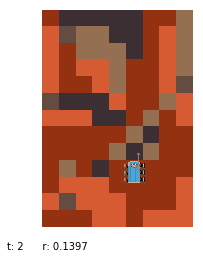

(5, 9) b'F'
(5, 8) b'2'


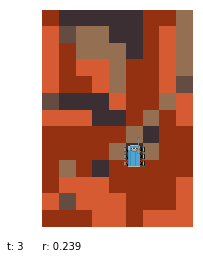

(5, 8) b'2'
(5, 7) b'1'


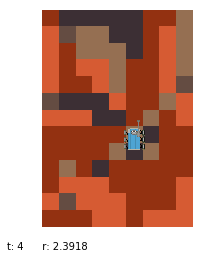

(5, 7) b'1'
(5, 6) b'F'


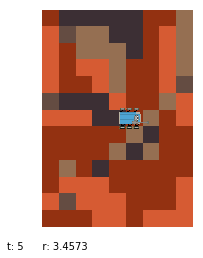

(5, 6) b'F'
(6, 6) b'1'


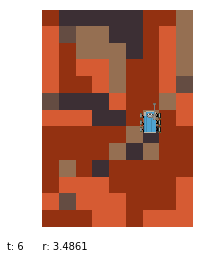

(6, 6) b'1'
(6, 5) b'S'


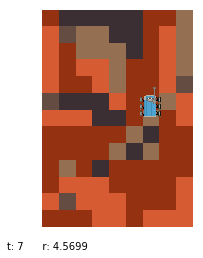

(6, 5) b'S'
(6, 4) b'F'


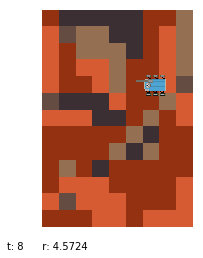

(6, 4) b'F'
(6, 3) b'F'


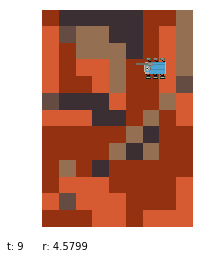

(6, 3) b'F'
(5, 3) b'S'


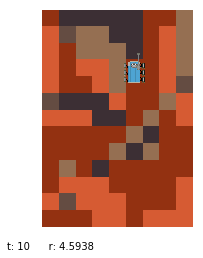

(5, 3) b'S'
(5, 2) b'2'


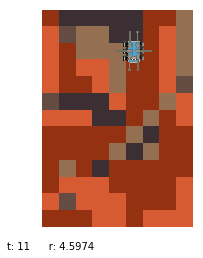

(5, 2) b'2'
(5, 2) b'2'


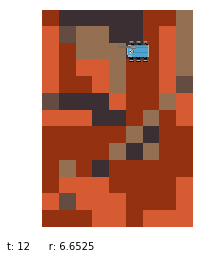

(5, 2) b'2'
(4, 2) b'1'


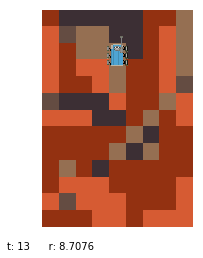

(4, 2) b'1'
(4, 1) b'2'


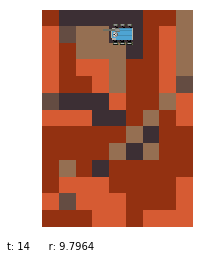

(4, 1) b'2'
(4, 2) b'1'


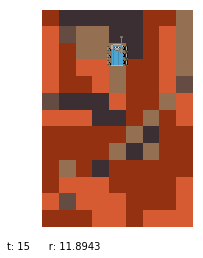

(4, 2) b'1'
(4, 1) b'2'


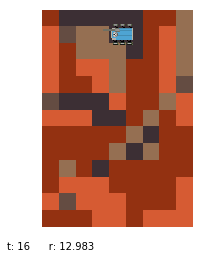

(4, 1) b'2'
(3, 1) b'1'


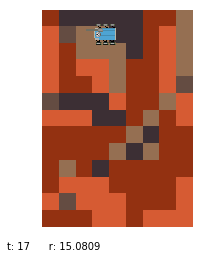

(3, 1) b'1'
(3, 2) b'1'


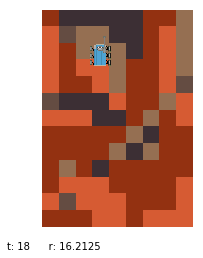

(3, 2) b'1'
(2, 2) b'1'


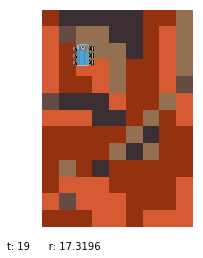

(2, 2) b'1'
(3, 2) b'1'


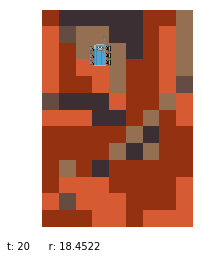

(3, 2) b'1'
(3, 1) b'1'


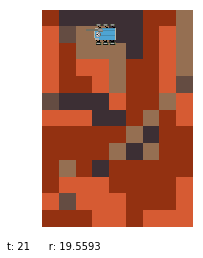

(3, 1) b'1'
(2, 1) b'1'


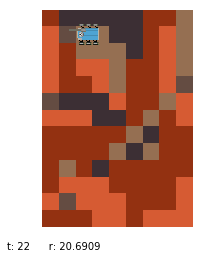

(2, 1) b'1'
(2, 2) b'1'


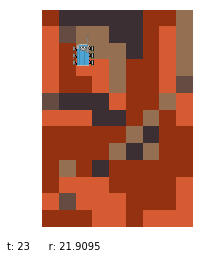

(2, 2) b'1'
(2, 1) b'1'


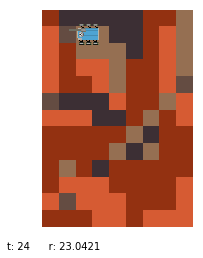

(2, 1) b'1'
(1, 1) b'3'


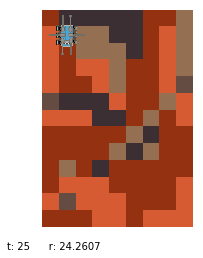

(1, 1) b'3'
(1, 1) b'3'


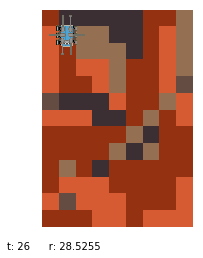

(1, 1) b'3'
(1, 1) b'3'


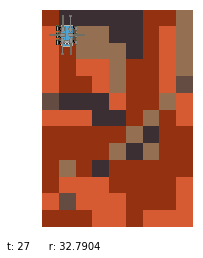

(1, 1) b'3'
(1, 1) b'3'


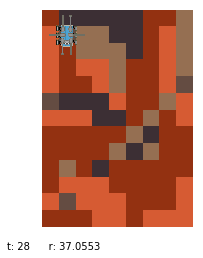

(1, 1) b'3'
(1, 1) b'3'


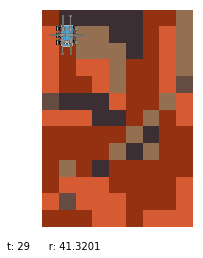

(1, 1) b'3'
(1, 1) b'3'


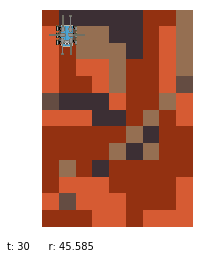

(1, 1) b'3'
(1, 1) b'3'


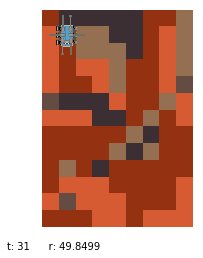

(1, 1) b'3'
(1, 1) b'3'


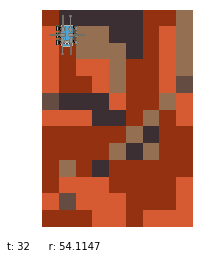

(1, 1) b'3'
(1, 1) b'3'


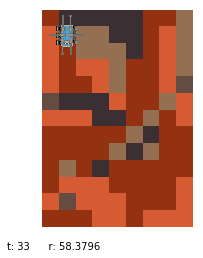

(1, 1) b'3'
(1, 1) b'3'


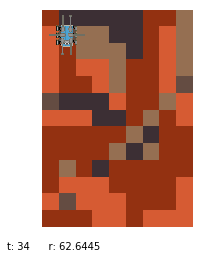

(1, 1) b'3'
(1, 1) b'3'


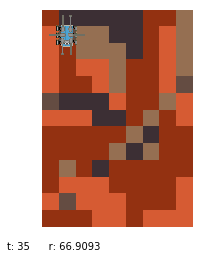

(1, 1) b'3'
(1, 1) b'3'


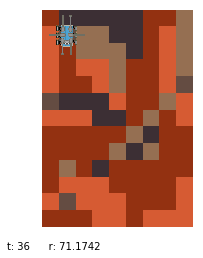

(1, 1) b'3'
(1, 1) b'3'


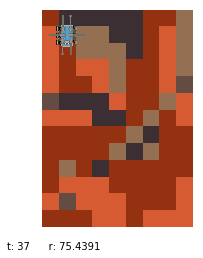

(1, 1) b'3'
(1, 1) b'3'


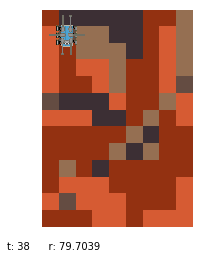

(1, 1) b'3'
(1, 1) b'3'


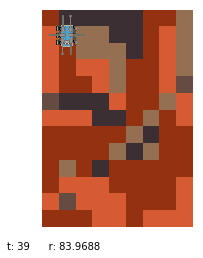

(1, 1) b'3'
(1, 1) b'3'
[[[0.7489598  0.01661873]
  [0.12273616 0.01032241]
  [0.00000002 0.01097514]
  [0.128304   0.00675626]
  [0.00000002 0.95532746]]

 [[0.18601049 0.01661873]
  [0.69708253 0.01032241]
  [0.11690665 0.01097514]
  [0.00000017 0.00675626]
  [0.00000017 0.95532746]]

 [[0.00000006 0.01661873]
  [0.12085146 0.01032241]
  [0.72251476 0.01097514]
  [0.15663367 0.00675626]
  [0.00000006 0.95532746]]

 [[0.14063572 0.01661873]
  [0.00000002 0.01032241]
  [0.0984452  0.01097514]
  [0.76091904 0.00675626]
  [0.00000002 0.95532746]]

 [[0.00000001 0.01661873]
  [0.00000001 0.01032241]
  [0.00000001 0.01097514]
  [0.00000001 0.00675626]
  [0.99999997 0.95532746]]]


In [56]:
plot_mars(mdp,tabsoftq_gen_pol(Qi))
print(softmax(Ti_thetas))

In [59]:
Qi.shape

(117, 5)

In [65]:
softmax(Ti_thetas).transpose((2,0,1))

array([[[0.74835885, 0.12284243, 0.00000002, 0.12879868, 0.00000002],
        [0.18600954, 0.69696629, 0.11702383, 0.00000017, 0.00000017],
        [0.00000006, 0.12134723, 0.7221528 , 0.15649986, 0.00000006],
        [0.14150809, 0.00000002, 0.09904106, 0.75945082, 0.00000002],
        [0.00000001, 0.00000001, 0.00000001, 0.00000001, 0.99999997]],

       [[0.01661   , 0.01031755, 0.01096978, 0.00675251, 0.95535015],
        [0.01661   , 0.01031755, 0.01096978, 0.00675251, 0.95535015],
        [0.01661   , 0.01031755, 0.01096978, 0.00675251, 0.95535015],
        [0.01661   , 0.01031755, 0.01096978, 0.00675251, 0.95535015],
        [0.01661   , 0.01031755, 0.01096978, 0.00675251, 0.95535015]]])

In [43]:
tabsoftq_gen_pol_probs(Qi)

array([0.02223182, 0.117746  , 0.09106168, 0.1374709 , 0.14176623,
       0.14099607, 0.02644417, 0.04406414, 0.11926129, 0.2       ,
       0.99789536, 0.04655413, 0.04693375, 0.1216617 , 0.13274746,
       0.02266679, 0.2       , 0.13336854, 0.2       , 0.01852296,
       0.04842858, 0.05046716, 0.04193997, 0.08015846, 0.02220864,
       0.2       , 0.13470806, 0.2       , 0.02955232, 0.2       ,
       0.2       , 0.06212652, 0.02167367, 0.02422936, 0.2       ,
       0.0840812 , 0.2       , 0.03303228, 0.03027286, 0.2       ,
       0.04336248, 0.02496619, 0.02656555, 0.2       , 1.        ,
       1.        , 0.15646083, 0.20322759, 0.23533399, 0.2       ,
       0.01792521, 0.03073178, 0.10804924, 0.2       , 0.2       ,
       0.2       , 0.2       , 0.26007403, 0.23473488, 0.02184262,
       0.09316492, 0.03896799, 0.2       , 0.06028736, 0.05760008,
       0.05271302, 0.04085675, 0.03894661, 0.07338487, 0.23027797,
       0.03452568, 0.05019384, 0.05505937, 0.02787771, 0.05241

In [44]:
print(softmax(Ti_thetas)) # - softmax(T_estimate(adt_obs[train_demo_example_idxes])))

[[[0.73929802 0.020167  ]
  [0.12049617 0.01225457]
  [0.00000002 0.01307867]
  [0.14020576 0.00806576]
  [0.00000002 0.946434  ]]

 [[0.20134535 0.020167  ]
  [0.67597779 0.01225457]
  [0.12267651 0.01307867]
  [0.00000017 0.00806576]
  [0.00000017 0.946434  ]]

 [[0.00000006 0.020167  ]
  [0.11182617 0.01225457]
  [0.72448691 0.01307867]
  [0.16368681 0.00806576]
  [0.00000006 0.946434  ]]

 [[0.14163339 0.020167  ]
  [0.00000002 0.01225457]
  [0.10441812 0.01307867]
  [0.75394846 0.00806576]
  [0.00000002 0.946434  ]]

 [[0.00000001 0.020167  ]
  [0.00000001 0.01225457]
  [0.00000001 0.01307867]
  [0.00000001 0.00806576]
  [0.99999997 0.946434  ]]]


In [ ]:
test_T_likelihood(softmax(Ti_thetas), val_sas_obs, val_adt_obs)

In [ ]:
test_T_likelihood(softmax(T_estimate(adt_obs[train_demo_example_idxes])), val_sas_obs, val_adt_obs)

In [ ]:
test_T_likelihood(true_tps, val_sas_obs, val_adt_obs)

In [ ]:
true_trans_loss(softmax(Ti_thetas))

In [ ]:
softmax(Ti_thetas)

In [ ]:
true_trans_loss(softmax(T_estimate(adt_obs[train_demo_example_idxes])))

In [ ]:
softmax(T_estimate(adt_obs[train_demo_example_idxes]))

In [ ]:
plot_values(mdp, Qi)

In [ ]:
plot_values(mdp, exQs)

## SERD only

In [ ]:
serd_train_logs = {
  'train_likelihoods': [],
  'val_likelihoods': [],
  'tp_lls': [],
  'tt_lls': [],
  'vp_lls': [],
  'vt_lls': [],
  'true_trans_loss': []
}

In [ ]:
Ts_thetas = T_estimate(adt_obs[train_demo_example_idxes]) #np.log(Tps2+.000000001)
feats = mdp.feature_map
Rs_thetas = np.random.normal(loc=1,scale=0.1,size=feats.shape[1])
Qs = None

In [ ]:
maxiter = 300
t_learning_rate = lambda t: 0 if t<20 else 3 - (2 * int(t/(maxiter/2)))
r_learning_rate = lambda t: 2e-1 if t<20 else 1e-1

In [ ]:
while len(serd_train_logs['tt_lls']) < maxiter:
    prevQs = Qs.copy() if Qs is not None else None
    t = len(serd_train_logs['tt_lls'])
    batch_demo_sas, batch_demo_adt = sample_batch(batch_size, train_demo_example_idxes, sas_obs, adt_obs)
    Rs = feats.dot(Rs_thetas)
    tp_ll, dT_pol, dR_pol, Qs = eval_TR_pol_likelihood_and_grad(Ts_thetas, Rs, feats, batch_demo_sas, Q_inits=Qs)
    tt_ll, dT_trans = eval_trans_likelihood_and_grad(Ts_thetas, batch_demo_adt)
    train_likelihood = tp_ll + tt_ll
    vp_ll, vt_ll = eval_demo_log_likelihood(val_sas_obs, val_adt_obs, Ts_thetas, Qs)
    val_likelihood = vp_ll + vt_ll
    ttd = true_trans_loss(softmax(Ts_thetas))
    Rs_thetas += r_learning_rate(t) * dR_pol
    Ts_thetas += t_learning_rate(t) * (dT_trans + dT_pol)

#     print(dT_trans)
#     print(dT_pol)
#     print(softmax(Ts_thetas))
#     print(dR_pol * r_learning_rate(t))
#     print(Rs_thetas)
#     if prevQs is not None:
#         print("Q_diff")
#         print(np.linalg.norm(Qs-prevQs))

    
    print('%d %f %f %f %f' % (t, vp_ll, vt_ll, vp_ll + vt_ll, ttd))
    serd_train_logs['train_likelihoods'].append(train_likelihood)
    serd_train_logs['val_likelihoods'].append(val_likelihood)
    serd_train_logs['tp_lls'].append(tp_ll)
    serd_train_logs['tt_lls'].append(tt_ll)
    serd_train_logs['vp_lls'].append(vp_ll)
    serd_train_logs['vt_lls'].append(vt_ll)
    serd_train_logs['true_trans_loss'].append(ttd)

In [ ]:
print(softmax(Ts_thetas))

In [ ]:
print(Rs_thetas)

In [ ]:
true_trans_loss(softmax(Ts_thetas))

In [ ]:
plt.plot(serd_train_logs['vp_lls'][:250])
plt.plot(idl_train_logs['vp_lls'][:250])

In [ ]:
plt.plot(serd_train_logs['vt_lls'][:250])
plt.plot(idl_train_logs['vt_lls'][:250])

In [ ]:
plt.plot(serd_train_logs['val_likelihoods'], label = "SERD")
plt.plot(idl_train_logs['val_likelihoods'], label = "IDL")
plt.title("Log likelihood of Demonstrations")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Log Likelihood")
plt.legend()

In [ ]:
plt.plot(serd_train_logs['true_trans_loss'], label = "SERD")
plt.plot(idl_train_logs['true_trans_loss'], label = "IDL")
plt.title("Square Error of Learned Transition Parameters")
plt.xlabel("Iterations of MDCE")
plt.ylabel("Summed Square Error")
plt.legend()

## Comparison Tests

In [ ]:
def demo_stats(mdp, demos):
    demo_rewards = []
    for i in range(len(demos)):
        demo_rewards += [np.array([mdp.rewards[obs[0][2]] for obs in demos[i]])]
#         for j in range(len(demo_rewards[i])):
#             print(demos[i][j][0], demo_rewards[i][j])
    
    discounted_demo_rewards = [np.power(gamma,np.arange(len(dr)))*dr for dr in demo_rewards]
    demo_rewards, discounted_demo_rewards = np.array(demo_rewards), np.array(discounted_demo_rewards)
    data = {"mean episode reward": np.mean(np.sum(demo_rewards, axis=1)),
            "sd episode reward": np.std(np.sum(demo_rewards, axis=1)),
            "mean discounted episode reward": np.mean(np.sum(discounted_demo_rewards, axis=1)),
            "sd discounted episode reward": np.std(np.sum(discounted_demo_rewards, axis=1))}
    return data
    
    

In [ ]:
SERD_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qs), 2000, demo_time_steps)
IDL_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qi), 2000, demo_time_steps)

In [ ]:
print(demo_stats(mdp, SERD_demos))

In [ ]:
print(demo_stats(mdp, IDL_demos))

In [ ]:
plot_values(mdp, Qs)

In [ ]:
plot_values(mdp, Qi)

In [ ]:
print(reward_map[5][0], Qi[2], Q[2])

### Transfer

In [ ]:
tile_map2 = [
        "2FFFFFFF1",
        "FFFFFFFFF",
        "FFFFUFFFF",
        "FFFUUUFSF",
        "FFUU3UUFF",
        "FSFUUUFSF",
        "FSFFUFFSF",
        "FFFSSSFFF",
        "1FFFFFFF2"
    ]
reward_map2, texture_map2 = build_reward_map(tile_map2, tile_rewards, goal_tile_rewards, tile_reward_modifier)
# reward_normalizer2 = (1-gamma)/(np.max(reward_map2))
# reward_map2 *= reward_normalizer2
# time_penalty *= reward_normalizer2
# temperature2 = 1/(reward_normalizer2)
# print(temperature2)
print(reward_map2)
print(texture_map2)

In [ ]:
mdp = MarsExplorerEnv(tile_map2, reward_map2, texture_map2, trans_dict, time_penalty) 
nA = mdp.num_actions
nS = mdp.num_states

In [ ]:

Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tips = softmax(Ti_thetas,axis=1)
Ti = mdp.adt_trans_to_sas_trans(Tips)
Ri = mdp.rewards
Qit = tabsoftq_iter(Ri, Ti, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
Tsps = softmax(Ts_thetas,axis=1)
Ts = mdp.adt_trans_to_sas_trans(Tips)
Rs = mdp.feature_map.dot(Rs_thetas)
Qst = tabsoftq_iter(Rs, Ts, maxiter=tabsoftq_iter_maxiter, verbose=tabsoftq_iter_verbose, ftol=tabsoftq_iter_ftol)

In [ ]:
IDL_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qit), 1000, demo_time_steps)
SERD_trans_demos = generate_demonstrations(mdp, tabsoftq_gen_pol(Qst), 1000, demo_time_steps)

In [ ]:
plot_mars(mdp,tabsoftq_gen_pol(Qit),Qs=Qit)

In [ ]:
print(demo_stats(mdp, IDL_trans_demos))

In [ ]:
print(demo_stats(mdp, SERD_trans_demos))

In [ ]:
plot_values(mdp, Qit)

In [ ]:
plot_values(mdp, Qst)

In [ ]:
Qtrue = tabsoftq_learn_Qs(mdp)
plot_values(mdp,Qtrue)